# Supervised Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA

## Step 1: Load and Explore the Data
Tasks:
- Load the dataset and inspect its structure.

- Check for missing values and duplicates.

- Analyze the target distribution (diagnosis).

diagnosis
B    357
M    212
Name: count, dtype: int64


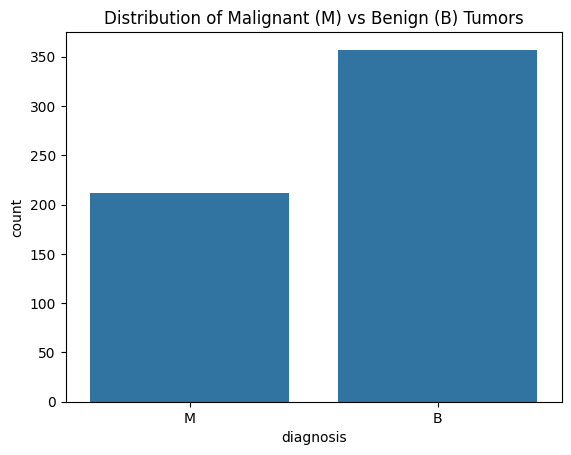

In [2]:
df = pd.read_csv("datasets/breast-cancer-dataset/breast-cancer.csv")

# Drop irrelevant columns like 'id' (if present)
df.drop(columns=['id'], inplace=True, errors='ignore')

# Check target distribution
print(df['diagnosis'].value_counts())
sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Malignant (M) vs Benign (B) Tumors')
plt.show()

## Step 2: Preprocess the Data
Tasks:
- Encode the target variable (M=1, B=0).

- Split into features (X) and target (y).

- Scale features (critical for SVMs).

In [3]:
# Encode target
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Split data
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 3: Feature Selection & Dimensionality Reduction
Tasks:
- Check for multicollinearity.

- Use PCA to reduce dimensionality (optional but recommended for high-dimensional data).

OBS.: PCA transforms your original features into new, uncorrelated components that capture the maximum variance in the data. These components are linear combinations of the original features:

* PC1: The direction of maximum variance in the data (most important).

* PC2: The direction of second-most variance, orthogonal to PC1.

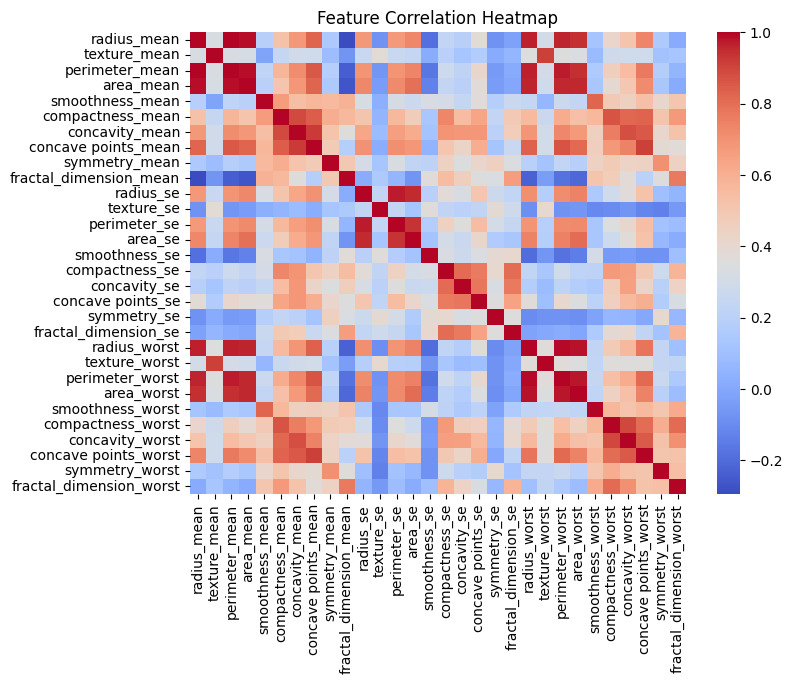

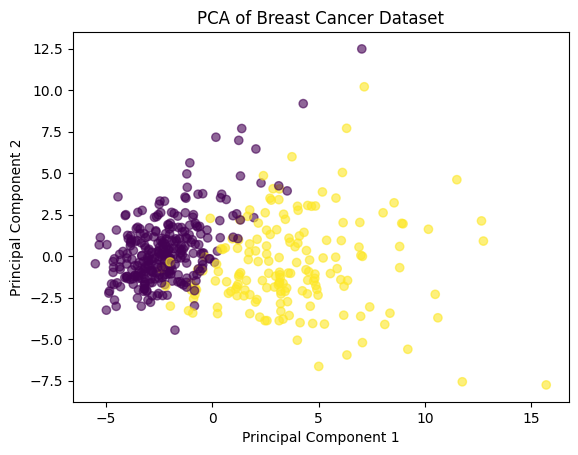

In [4]:
# Check correlations
corr_matrix = X_train.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# PCA for visualization (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Breast Cancer Dataset')
plt.show()

In [5]:
# Get loadings (weights of original features in each component)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for interpretation
loadings_df = pd.DataFrame(
    loadings,
    columns=['PC1', 'PC2'],
    index=X.columns  # Original feature names
)
print("Feature Contributions to PC1 and PC2:")
print(loadings_df)

Feature Contributions to PC1 and PC2:
                              PC1       PC2
radius_mean              0.794784 -0.566188
texture_mean             0.373119 -0.145300
perimeter_mean           0.826812 -0.521731
area_mean                0.802185 -0.559456
smoothness_mean          0.544076  0.418101
compactness_mean         0.885851  0.330399
concavity_mean           0.943826  0.141889
concave points_mean      0.953425 -0.095711
symmetry_mean            0.520267  0.457179
fractal_dimension_mean   0.262146  0.865773
radius_se                0.749503 -0.260383
texture_se               0.074000  0.179088
perimeter_se             0.769200 -0.222945
area_se                  0.732056 -0.371034
smoothness_se            0.084820  0.449913
compactness_se           0.642026  0.529019
concavity_se             0.552160  0.477031
concave points_se        0.675507  0.314794
symmetry_se              0.184538  0.411182
fractal_dimension_se     0.391793  0.652205
radius_worst             0.829752 -0.5

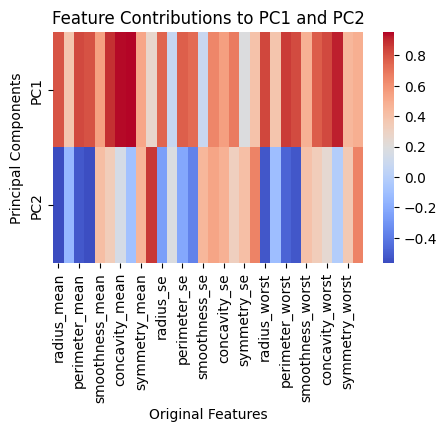

In [6]:
# Plot feature contributions to PC1 and PC2
plt.figure(figsize=(5, 3))
sns.heatmap(
    loadings_df.T,
    cmap='coolwarm',
    annot=False,
    cbar=True
)
plt.title('Feature Contributions to PC1 and PC2')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()

Dropping highly correlated columns

In [7]:
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Identify pairs with correlation > threshold (e.g., 0.9)
high_corr = np.where(corr_matrix > 0.8)

# Extract unique feature pairs
high_corr = [(corr_matrix.columns[x], corr_matrix.columns[y]) 
             for x, y in zip(*high_corr) 
             if x != y and x < y]

# Collect features to drop
drop_features = set()
for col1, col2 in high_corr:
    if col1 not in drop_features and col2 not in drop_features:
        # Keep the first feature, drop the second (adjust logic as needed)
        drop_features.add(col2)

# Drop redundant features
X_train_reduced = X_train.drop(columns=drop_features)
X_test_reduced = X_test.drop(columns=drop_features)

print(f"Dropped features: {drop_features}")

Dropped features: {'area_mean', 'area_worst', 'fractal_dimension_se', 'concave points_worst', 'smoothness_worst', 'radius_worst', 'concavity_se', 'concave points_mean', 'texture_worst', 'perimeter_worst', 'concavity_worst', 'concavity_mean', 'area_se', 'compactness_worst', 'perimeter_mean', 'perimeter_se'}


In [8]:
# Example: Retrain SVM
svm_reduced = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = svm_reduced.predict(X_test_reduced)
print(classification_report(y_test, y_pred_reduced))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        72
           1       0.94      0.76      0.84        42

    accuracy                           0.89       114
   macro avg       0.91      0.87      0.88       114
weighted avg       0.90      0.89      0.89       114



## Step 4: Train and Optimize the SVM Model
Tasks:
- Use GridSearchCV to tune hyperparameters.

- Evaluate performance on the test set.

In [9]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Initialize SVM and GridSearch
svm = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")
best_svm = grid_search.best_estimator_

Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


## Step 5: Evaluate the Model
Tasks:
- Generate classification reports and ROC curves.

- Analyze feature importance (for linear kernels).

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



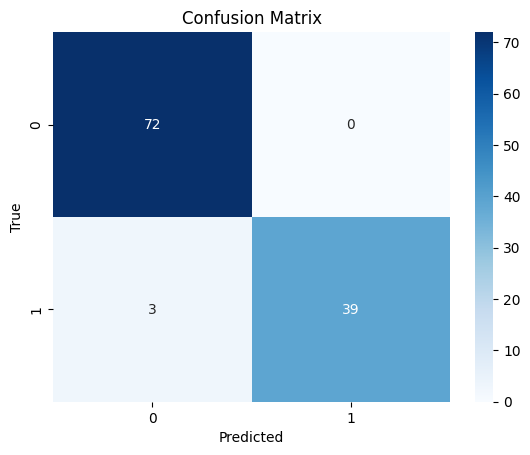

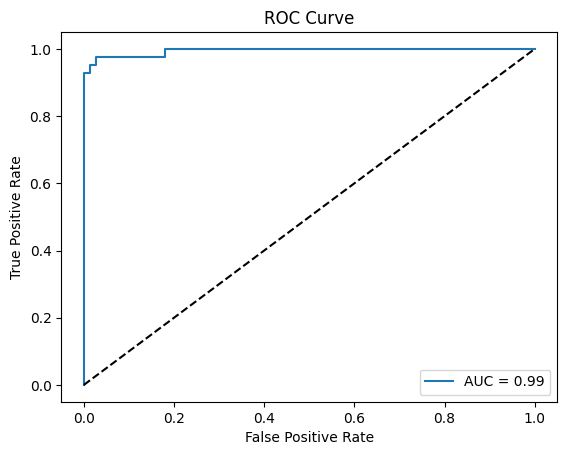

In [10]:
# Predictions
y_pred = best_svm.predict(X_test_scaled)
y_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature importance (for linear kernel)
if best_svm.kernel == 'linear':
    coef = best_svm.coef_[0]
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coef)})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Features by Importance (Linear SVM)')
    plt.show()

Reviewing Misclassified Samples:

In [11]:
# Get misclassified malignant tumors (FN)
fn_mask = (y_test == 1) & (y_pred == 0)
fn_samples = X_test[fn_mask]
print(fn_samples)

    radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
99        14.42         19.77           94.48      642.5          0.09752   
73        13.80         15.79           90.43      584.1          0.10070   
86        14.48         21.46           94.25      648.2          0.09444   

    compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
99           0.11410         0.09388              0.05839         0.1879   
73           0.12800         0.07789              0.05069         0.1662   
86           0.09947         0.12040              0.04938         0.2075   

    fractal_dimension_mean  ...  radius_worst  texture_worst  perimeter_worst  \
99                 0.06390  ...         16.33          30.86            109.5   
73                 0.06566  ...         16.57          20.86            110.3   
86                 0.05636  ...         16.21          29.25            108.4   

    area_worst  smoothness_worst  compactness_worst  concavit

In [12]:
svm = SVC(class_weight='balanced', probability=True, random_state=42)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

Cross-Validation Accuracy: 0.91 ± 0.02


In [13]:
# For linear SVM
svm_linear = SVC(kernel='linear', C=1, random_state=42)
svm_linear.fit(X_train_scaled, y_train)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Weight': svm_linear.coef_[0]})
feature_importance.sort_values('Weight', key=abs, ascending=False).head(10)

,Feature,Weight
21,texture_worst,1.071995
6,concavity_mean,0.880175
13,area_se,0.829700
7,concave points_mean,0.827597
26,concavity_worst,0.824417
10,radius_se,0.755905
23,area_worst,0.725480
11,texture_se,-0.613818
20,radius_worst,0.541589
15,compactness_se,-0.535861


## Looking for Overfitting
- If training metrics >> test metrics → Overfitting.

- If both are low → Underfitting.

- If both are high and close → Good generalization.

In [14]:
# Predict on training data (never do this for final evaluation!)
y_train_pred = best_svm.predict(X_train_scaled)
y_train_proba = best_svm.predict_proba(X_train_scaled)[:, 1]

# Training metrics
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))
print(f"Training AUC: {roc_auc_score(y_train, y_train_proba):.2f}")

# Test metrics (already done earlier)
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Test AUC: {roc_auc_score(y_test, y_proba):.2f}")

Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       285
           1       1.00      0.96      0.98       170

    accuracy                           0.99       455
   macro avg       0.99      0.98      0.99       455
weighted avg       0.99      0.99      0.99       455

Training AUC: 1.00

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Test AUC: 0.99


**Cross-Validation**

Use k-fold cross-validation to assess stability across different splits:

- If CV accuracy ≈ test accuracy → No overfitting.

- If CV accuracy << test accuracy → Overfitting (model tuned to a lucky split).

In [15]:
from sklearn.model_selection import cross_val_score

X_scaled = scaler.fit_transform(X)
# 5-fold cross-validation on full dataset (X_scaled)
svm = SVC(C=10, gamma='scale', kernel='rbf', random_state=42)
cv_scores = cross_val_score(svm, X_scaled, y, cv=5, scoring='accuracy')

print(f"CV Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

CV Accuracy: 0.98 ± 0.01


**Learning Curves**

- Overfitting: Large gap between training and validation curves.

- Good Fit: Curves converge at high accuracy as data increases.

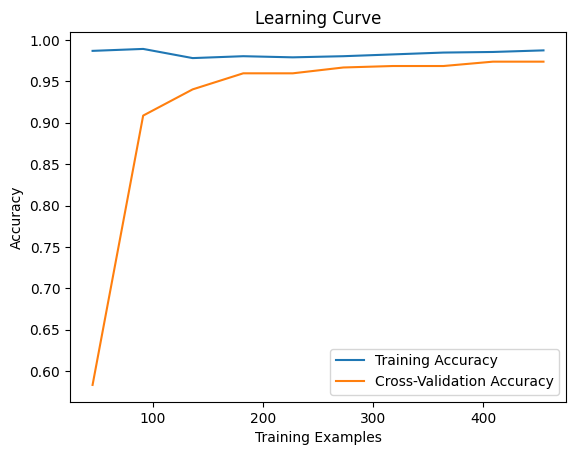

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_svm, X_scaled, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, test_mean, label='Cross-Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

**Feature Importance Analysis**

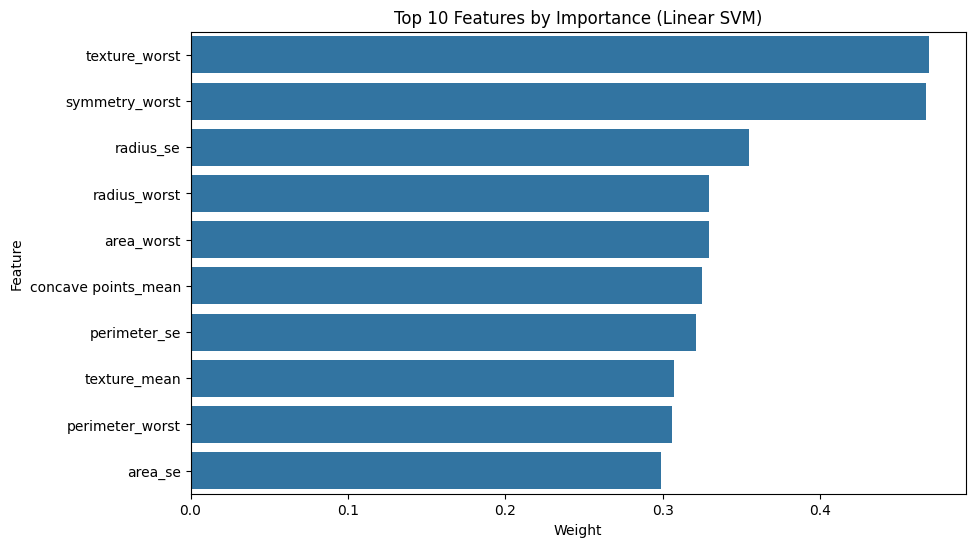

In [17]:
# For linear SVM
svm_linear = SVC(kernel='linear', C=0.1, random_state=42)
svm_linear.fit(X_train_scaled, y_train)

# Plot feature weights
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Weight': svm_linear.coef_[0]
}).sort_values('Weight', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features by Importance (Linear SVM)')
plt.show()

# Unsupervised + LLM approach

## Step 1: Clustering (K-Means with PCA visualization)

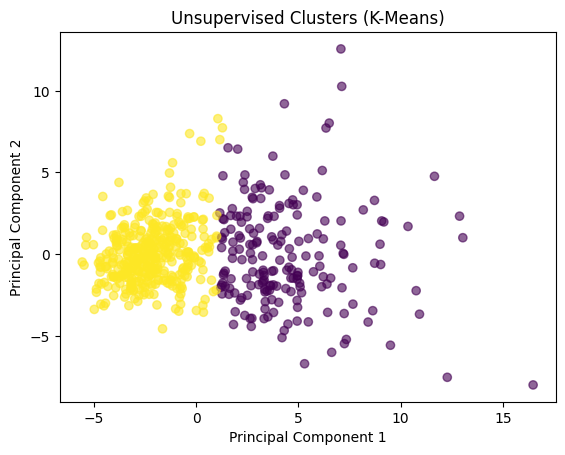

In [18]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data and drop labels (treat as unsupervised)
df = pd.read_csv("datasets/breast-cancer-dataset/breast-cancer.csv")
X = df.drop(columns=['diagnosis'])  # Remove the target variable

# Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster (assume 2 clusters for benign/malignant alignment)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters  # Add cluster labels

# Visualize with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Unsupervised Clusters (K-Means)')
plt.show()

## Step 2: Generate Cluster Summaries

In [19]:
# Group by cluster and compute mean/std of key features
cluster_summary = df.groupby('Cluster').agg({
    'radius_mean': ['mean', 'std'],
    'texture_mean': ['mean', 'std'],
    'concave points_worst': ['mean', 'std'],
    'area_worst': ['mean', 'std']
}).reset_index()

# Print in a format suitable for LLM prompting
print(cluster_summary.to_markdown())
cluster_summary_md = cluster_summary.to_markdown()

|    |   ('Cluster', '') |   ('radius_mean', 'mean') |   ('radius_mean', 'std') |   ('texture_mean', 'mean') |   ('texture_mean', 'std') |   ('concave points_worst', 'mean') |   ('concave points_worst', 'std') |   ('area_worst', 'mean') |   ('area_worst', 'std') |
|---:|------------------:|--------------------------:|-------------------------:|---------------------------:|--------------------------:|-----------------------------------:|----------------------------------:|-------------------------:|------------------------:|
|  0 |                 0 |                   17.6007 |                  3.43355 |                    21.404  |                   4.00091 |                          0.190348  |                         0.0405066 |                 1457.36  |                  632.17 |
|  1 |                 1 |                   12.4134 |                  1.96149 |                    18.2464 |                   4.05841 |                          0.0772324 |                         0.037

In [20]:
# Tabela de contingência para ver quantos turmores benignos/malignos em cada cluster
cross_tab = pd.crosstab(df['Cluster'], df['diagnosis'])
print(cross_tab)

diagnosis    B    M
Cluster            
0           13  175
1          344   37


In [21]:
prompt = f"""
I clustered breast cancer tumor data into 2 groups (Cluster 0 and 1) without using diagnosis labels. Here are the feature summaries:

{cluster_summary_md}

Key medical features:
- `radius_mean`: Larger radii often indicate malignancy.
- `concave points_worst`: Higher values suggest aggressive tumors.
- `texture_mean`: Measures tumor cell uniformity.

Based on these statistics:
1. Which cluster (0 or 1) likely represents malignant tumors? Justify your answer.
2. Describe the clinical characteristics of each cluster.
"""

In [22]:
from dotenv import load_dotenv
import openai
import os

load_dotenv()

client = openai.OpenAI(
    organization='org-8Q6LduybHrpbAdbT9yJUJDQA',
    project='proj_DjkXbEEukpsg44dLeabG1ZyP',
    api_key=os.environ.get('OPENAI_API_KEY'),
)

def generateResponseLLM(model: str, messages: list , max_tokens: int) -> str:
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=max_tokens,
        temperature=0.25
    )
    return response.choices[0].message.content

# Configurar a chave da OpenAI (pode ser via variável de ambiente)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [23]:
messages = [
    {
        "role": "system",
        "content": "You are an expert in data analysis and machine learning. I received a dataset that was segmented into groups using an unsupervised clustering algorithm. Each group contains observations with similar characteristics, but we don't yet know which classification each one fits into."
    },
    {
        "role": "user",
        "content": prompt
    }
]

resposta_llm = generateResponseLLM('gpt-4o-mini', messages, 4600)
print(resposta_llm)

Based on the provided feature summaries for the two clusters, we can analyze the characteristics of each cluster to infer which one likely represents malignant tumors.

### 1. Which cluster likely represents malignant tumors?

**Cluster 0**:
- **Radius Mean**: 17.6007 (higher value)
- **Concave Points Worst Mean**: 0.190348 (higher value)
- **Area Worst Mean**: 1457.36 (higher value)

**Cluster 1**:
- **Radius Mean**: 12.4134 (lower value)
- **Concave Points Worst Mean**: 0.0772324 (lower value)
- **Area Worst Mean**: 595.981 (lower value)

**Justification**:
- The **radius_mean** in Cluster 0 is significantly higher than in Cluster 1. Larger tumor radii are often associated with malignancy.
- The **concave points_worst** mean is also higher in Cluster 0. A higher number of concave points suggests a more aggressive tumor, which is typically seen in malignant tumors.
- The **area_worst** is also much larger in Cluster 0, indicating a larger tumor size, which is often correlated with mal